In [1]:
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
plt.rcParams.update({'font.size': 26})


gpus = tf.config.experimental.list_physical_devices('GPU')
num_gpus = len(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(num_gpus, "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# # or turn GPU off:
# tf.config.set_visible_devices([], 'GPU')

1 Physical GPUs, 1 Logical GPUs


In [2]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, path, batch_size, num_examples=190_000, random_seed=42):
        self.path = path
        self.batch_size = batch_size
        self.num_examples = num_examples
        self.random_seed = random_seed
        self.on_epoch_end()

    def __len__(self):
        return self.num_examples // self.batch_size

    def on_epoch_end(self):
        np.random.seed(self.random_seed)
        self.random_seed += 1
        self.indices = np.arange(self.num_examples)
        np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_x = np.empty([self.batch_size, 8192, 1])
        batch_y = np.empty([self.batch_size, 8192, 1])
        for i, idx in enumerate(batch_indices):
            _, x, y = np.load(self.path+f'chromatogram_{idx}.npy')
            batch_x[i,] = x[:, np.newaxis]
            batch_y[i,] = y[:, np.newaxis]

        return np.array(batch_x), np.array(batch_y)

In [3]:
class CAE(tf.keras.Model):

    def __init__(self,
                 layer_sizes,
                 kernel_sizes,
                 stride_size,
                 input_shape,
                 name='autoencoder',
                 **kwargs):
        super(CAE, self).__init__(name=name, **kwargs)

        # Define Encoder
        self.encoder = tf.keras.Sequential()
        self.encoder.add(tf.keras.layers.Input(shape=input_shape))
        for i, (filter_size, kernel_size) in enumerate(zip(layer_sizes, kernel_sizes)):
            # print(filter_size, kernel_size)
            self.encoder.add(
                tf.keras.layers.Conv1D(
                    filters=filter_size,
                    kernel_size=kernel_size,
                    strides=stride_size,
                    activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                    name='conv1d_downsample_{}'.format(i),
                    padding='same'))

        # Define Decoder
        decoder_input_shape = (input_shape[0]//(stride_size**len(layer_sizes)), layer_sizes[-1])
        self.decoder = tf.keras.Sequential()
        self.decoder.add(tf.keras.layers.Input(shape=decoder_input_shape))
        for i, (filter_size, kernel_size) in enumerate(zip(reversed(layer_sizes), reversed(kernel_sizes))):

            self.decoder.add(
                tf.keras.layers.Conv1DTranspose(
                    filters=filter_size,
                    kernel_size=kernel_size,
                    strides=stride_size,
                    activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                    name='conv1d_upsample_{}'.format(i),
                    padding='same'))

        self.decoder.add(
            tf.keras.layers.Conv1DTranspose(
                filters=1,
                kernel_size=1,
                strides=1,
                activation='linear',
                name='conv1d_upsample_{}'.format(i+1),
                padding='same'))

        self.encoder._name = 'Encoder'
        self.decoder._name = 'Decoder'

        self.mae_loss = tf.keras.losses.MeanAbsoluteError()
        self.mae = tf.keras.metrics.Mean()

    @property
    def trainable_weights(self):
        return (
            self.encoder.trainable_weights +
            self.decoder.trainable_weights
        )

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            x = self(x, training=True)
            loss = self.mae_loss(y, x)
            self.mae.update_state(loss)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        return {
            'MAE_loss': self.mae.result(),
        }

    def call(self, inputs, training=False):
        x = self.encoder(inputs, training=training)
        x = self.decoder(x, training=training)
        return x

    @tf.function(input_signature=[
        tf.TensorSpec([8192], tf.float32),
    ])
    def smooth(self, chromatogram):
        x = chromatogram[tf.newaxis, :, tf.newaxis]
        x = self.encoder(x, training=False)
        x = self.decoder(x, training=False)
        return tf.squeeze(x)

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

In [4]:
cae = CAE(
    layer_sizes=[128, 128, 64, 64, 32],
    kernel_sizes=[7, 7, 7, 7, 7, 7],
    stride_size=2,
    input_shape=(8192, 1)
)

cae.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_downsample_0 (Conv1D) (None, 4096, 128)         1024      
_________________________________________________________________
conv1d_downsample_1 (Conv1D) (None, 2048, 128)         114816    
_________________________________________________________________
conv1d_downsample_2 (Conv1D) (None, 1024, 64)          57408     
_________________________________________________________________
conv1d_downsample_3 (Conv1D) (None, 512, 64)           28736     
_________________________________________________________________
conv1d_downsample_4 (Conv1D) (None, 256, 32)           14368     
Total params: 216,352
Trainable params: 216,352
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output 

In [5]:
generator = Generator(path='../input/simulations/train/', batch_size=32)
callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr * 0.5**epoch)
cae.compile(optimizer=tf.keras.optimizers.Adam(1e-3))
history = cae.fit(generator, epochs=1, verbose=1, callbacks=[callback])

5937/5937 [==============================] - 404s 68ms/step - MAE_loss: 2.0685


In [9]:
# # save the model
# tf.saved_model.save(cae, export_dir='../output/model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../output/model/assets


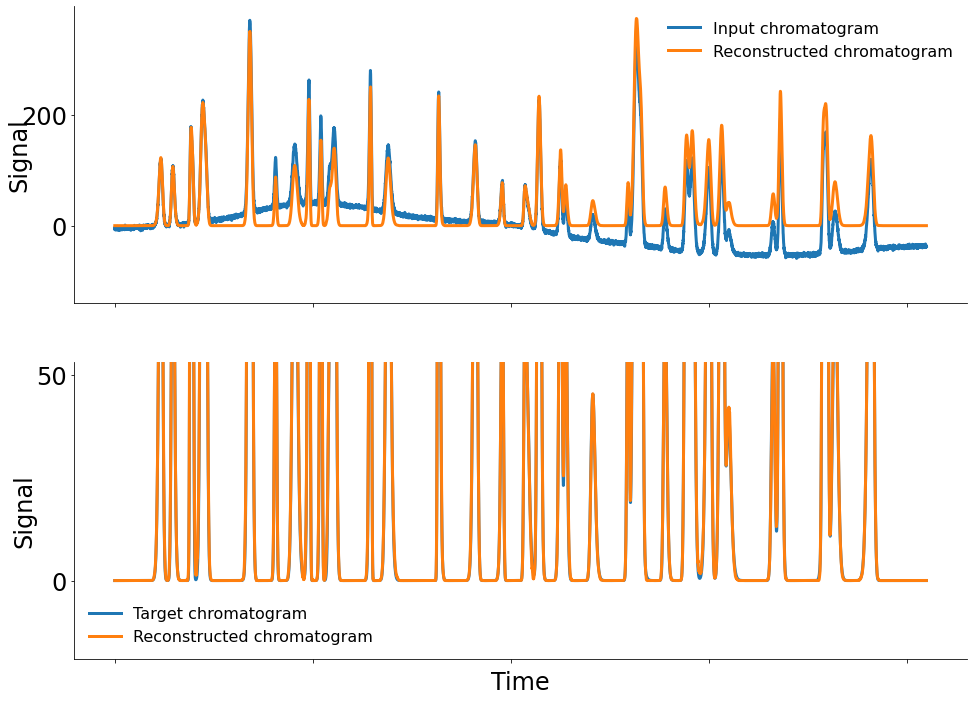

In [7]:
_, x, y = np.load(f'../input/simulations/test_white/chromatogram_{55}.npy')

fig, ax = plt.subplots(2, 1, figsize=(16, 12))
ax[0].set_ylabel('Signal', fontsize=24, labelpad=-10)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xticklabels([])
ax[0].tick_params(axis='both', which='major', labelsize=24)


ax[1].set_ylabel('Signal', fontsize=24, labelpad=0)
ax[1].set_xlabel('Time', fontsize=24)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xticklabels([])
ax[1].tick_params(axis='both', which='major', labelsize=24)

x_ = cae.smooth(x.astype('float32'))

ax[0].plot(
    x,
    color='C0',
    label='Input chromatogram',
    linewidth=3);
ax[0].plot(
    x_,
    color='C1',
    label='Reconstructed chromatogram',
    linewidth=3);
ax[0].legend(fontsize=16, frameon=False)
_, ylmax = ax[0].get_ylim()
ax[0].set_ylim(-140, ylmax)

ax[1].plot(
    y,
    color='C0',
    label='Target chromatogram',
    linewidth=3);
ax[1].plot(
    x_,
    color='C1',
    label='Reconstructed chromatogram',
    linewidth=3);

ax[1].legend(fontsize=16, frameon=False, loc=3)
_, ylmax = ax[1].get_ylim()
ax[1].set_ylim(-19, 53)

ax[0].set_yticks([0, 200])
ax[1].set_yticks([0, 50]);



(4000.0, 5000.0)

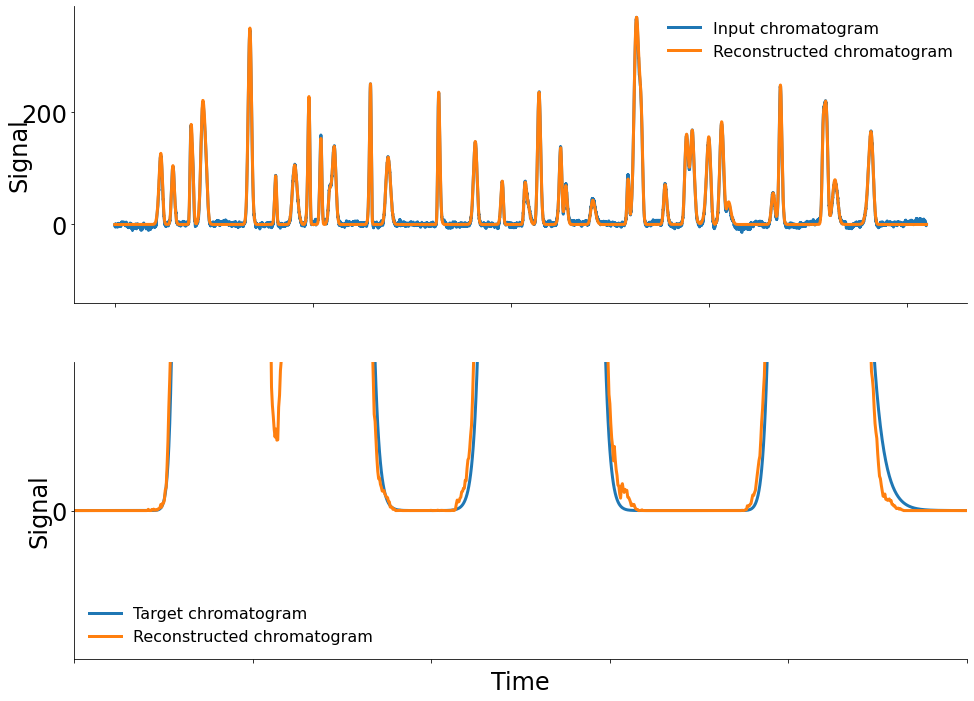

In [8]:
x, _, y = np.load(f'../input/simulations/test_pink/chromatogram_{55}.npy')

fig, ax = plt.subplots(2, 1, figsize=(16, 12))
ax[0].set_ylabel('Signal', fontsize=24, labelpad=-10)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xticklabels([])
# ax[0].set_yticklabels([])
ax[0].tick_params(axis='both', which='major', labelsize=24)


ax[1].set_ylabel('Signal', fontsize=24, labelpad=0)
ax[1].set_xlabel('Time', fontsize=24)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xticklabels([])
# ax[1].set_yticklabels([])
ax[1].tick_params(axis='both', which='major', labelsize=24)

x_ = cae.smooth(x.astype('float32'))

ax[0].plot(
    x,
    color='C0',
    label='Input chromatogram',
    linewidth=3);
ax[0].plot(
    x_,
    color='C1',
    label='Reconstructed chromatogram',
    linewidth=3);
ax[0].legend(fontsize=16, frameon=False)
_, ylmax = ax[0].get_ylim()
ax[0].set_ylim(-140, ylmax)


ax[1].plot(
    y,
    color='C0',
    label='Target chromatogram',
    linewidth=3);
ax[1].plot(
    x_,
    color='C1',
    label='Reconstructed chromatogram',
    linewidth=3);

ax[1].legend(fontsize=16, frameon=False, loc=3)
_, ylmax = ax[1].get_ylim()
ax[1].set_ylim(-19, 53)

ax[0].set_yticks([0, 200])
ax[1].set_yticks([0, 50])


ax[1].set_ylim(-1, 1)
ax[1].set_xlim(4000, 5000)